In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import cv2

In [2]:
%load_ext autoreload
%autoreload 2
from model import *
import dataloader as dl

In [3]:
data_path = "/home/zhaocheng/Research/DeepOpticsV2/GeomData/arc"
data_path = "/home/zhaocheng/Research/DeepOpticsV2/GeomData/GeomData"
dataloader = dl.DataLoader(data_path)
# print(dataloader.data_names)

/home/zhaocheng/Research/DeepOpticsV2/GeomGenerator/dataloader.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if blob['pattern'] != None:


In [4]:
import numpy as np
def recover_img(img, binary=False):
    # input: the 2-D tensor image with values from 0 to 1
    # output: 2-D greyscale image
    img = img * 255
    img.astype(np.int8)       
    # img = np.stack((img, )*3, -1)
    
    if binary==True:
        # res, img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
        img[img > 127] = 255
        img[img <= 127] = 0
        
    return img
    

In [31]:
def save_model(encoder, decoder, losses=None, savepath='./', name=0):
    # save net models
    if not os.path.exists(savepath):
        os.makedirs(savepath)
    
    if savepath == './':
        path_to_save = savepath + str(name) + '/'
    else:
        path_to_save = savepath + '/' + str(name) + '/'
    print(path_to_save)
    
    if os.path.exists(path_to_save):
        print("File path {} has already been created, model will not be save unless delete the directory".format(savepath + str(name) + '/'))
        return 0

    os.makedirs(path_to_save)
    torch.save(encoder.state_dict(), path_to_save + 'encoder_net.pth')
    torch.save(decoder.state_dict(), path_to_save + 'decoder_net.pth')
    
    if losses:
        np.save(path_to_save + "losses", losses)



In [34]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import trange
from matplotlib import colors
import matplotlib as mpl 

def train(encode_dim, niters, batchsize, dataloader, save_path=None):
    
    # define network
    encoder = GeomEncoder(encode_dim, 1, 64, 64)
    decoder = GeomDecoder(encode_dim, 0, 1, 64, 64)
    encoder.cuda()
    decoder.cuda()
    
    optimizer_e = optim.Adam(encoder.parameters(), lr=1e-3) 
    optimizer_d = optim.Adam(decoder.parameters(), lr=1e-3) 
    
    loss_MSE = nn.MSELoss(size_average=True)
    loss_L1 = nn.L1Loss()
    
    dataiter = dataloader.dataloader(batchsize)
    
    loss = []
    
    for n in trange(niters):
        input_data = Variable(next(dataiter).cuda(), requires_grad=False)
        optimizer_e.zero_grad()
        optimizer_d.zero_grad()
        
        latent = encoder(input_data)
        reconst = decoder(latent)
        
        reconst_loss = loss_MSE(reconst, input_data)
        
        reconst_loss.backward()
        optimizer_e.step()
        optimizer_d.step()
        
        if n % 100 == 0:
            if n % 2000 == 0:
                if save_path != None:      
                    save_model(encoder, decoder, losses=loss, savepath = save_path, name=str(n))
                    
            loss.append(reconst_loss.cpu().data.numpy()[0])
            clear_output(True)
            plt.plot(loss)
            plt.show()
            
            # get image and comparison
            cmap = mpl.cm.gray
            input_img = input_data.cpu().data.numpy()[0,0,:,:]
            recon_img = reconst.cpu().data.clamp_(0,1).numpy()[0,0,:,:]
            input_img, recon_img = recover_img(input_img), recover_img(recon_img, binary=True)
            plt.subplot(1,2,1)
            plt.imshow(input_img, cmap=cmap)
            plt.subplot(1,2,2)
            plt.imshow(recon_img, cmap=cmap)
            print(loss[-1])
            
    return loss

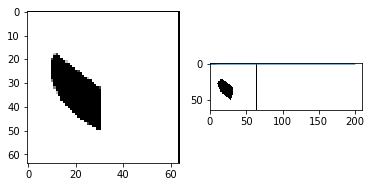

100%|█████████▉| 19903/20000 [16:28<00:04, 20.14it/s]

0.0060175


100%|██████████| 20000/20000 [16:32<00:00, 20.14it/s]


[0.64733303,
 0.38201517,
 0.33695239,
 0.33178213,
 0.32083851,
 0.31683329,
 0.32169801,
 0.313961,
 0.31577861,
 0.11358663,
 0.031157203,
 0.024494292,
 0.017497217,
 0.017371068,
 0.015268993,
 0.017512703,
 0.015492305,
 0.01374163,
 0.016369514,
 0.014701338,
 0.012780679,
 0.014941551,
 0.014804139,
 0.015901862,
 0.015191086,
 0.012027313,
 0.010578487,
 0.011737574,
 0.015378105,
 0.0122819,
 0.013752411,
 0.013409524,
 0.012255116,
 0.011916175,
 0.011929867,
 0.011564194,
 0.011889019,
 0.011900662,
 0.012262403,
 0.010983604,
 0.012344154,
 0.0099182306,
 0.012071813,
 0.011223952,
 0.011228657,
 0.011176935,
 0.011140113,
 0.011187589,
 0.011265752,
 0.01127901,
 0.010737445,
 0.0079388507,
 0.010616243,
 0.0097643621,
 0.013712029,
 0.0089066885,
 0.010050977,
 0.0098525966,
 0.010502144,
 0.0091340104,
 0.0095371585,
 0.011177558,
 0.010765757,
 0.0097482186,
 0.010161287,
 0.0099472636,
 0.0083002588,
 0.0098546231,
 0.0087310597,
 0.010468837,
 0.0093371496,
 0.007947

In [36]:
train(10, 20000, 128, dataloader, save_path='./Models')

In [37]:
def load_model(encode_dim, noise_dim=0, loadpath='./'):
    
    encoder = GeomEncoder(encode_dim, 1, 64, 64)
    decoder = GeomDecoder(encode_dim, 0, 1, 64, 64)
    encoder.load_state_dict(torch.load(loadpath + '/encoder_net.pth'))
    decoder.load_state_dict(torch.load(loadpath + '/decoder_net.pth'))
    
    return encoder, decoder

In [38]:
encoder, decoder = load_model(encode_dim=10, loadpath="/home/zhaocheng/Research/DeepOpticsV2/GeomGenerator/Models/18000")
encoder.cuda()
decoder.cuda()

GeomDecoder(
  (initial): TConvSet(
    (convSet): Sequential(
      (initial.10-512.transconv): ConvTranspose2d(10, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (initial.512.batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      (initial.512.ReLU): ReLU(inplace)
    )
  )
  (decoder): Sequential(
    (pyramid_1.512-256.transconv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid_1.256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid_1.256.ReLU): ReLU(inplace)
    (pyramid_2.256-128.transconv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid_2.128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid_2.128.ReLU): ReLU(inplace)
    (pyramid_3.128-64.transconv): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid_3.64.batchnorm): BatchNorm2d(64, ep

In [120]:
dataiter = dataloader.dataloader(128)
input_data = Variable(next(dataiter).cuda(), requires_grad=False)
latent = encoder(input_data)
print(latent)
z = latent.cpu().data.numpy()
print(z)
z1 = torch.mean(latent, 0, True) * 1
print(z1)

Variable containing:
-0.0050 -0.3153  1.5311  ...   0.4010 -0.3877 -0.7968
-0.3450 -0.8580 -0.9402  ...  -0.4913 -1.1406  1.0778
-1.7939 -2.4345  0.0230  ...  -0.8947 -1.4143 -2.0140
          ...             ⋱             ...          
-1.3286 -1.9425  1.1320  ...   0.3551  1.6288 -0.5600
 0.6570 -1.4196 -0.1883  ...  -1.2224  1.9462 -2.4900
-1.8160  0.0480  0.9738  ...  -0.8542 -2.0262 -0.2787
[torch.cuda.FloatTensor of size 128x10 (GPU 0)]

[[-0.00500587 -0.31528282  1.53109717 ...,  0.40103978 -0.38766012
  -0.79675519]
 [-0.34500268 -0.85801649 -0.9402051  ..., -0.4912774  -1.14058185
   1.07781792]
 [-1.79387796 -2.43451428  0.02302435 ..., -0.89473218 -1.41428971
  -2.01401234]
 ..., 
 [-1.32863319 -1.94246292  1.13204026 ...,  0.35508212  1.62875056
  -0.56003934]
 [ 0.65703112 -1.41960216 -0.18833512 ..., -1.22238243  1.94623899
  -2.49004412]
 [-1.81604731  0.04801644  0.97379637 ..., -0.85420161 -2.0262177
  -0.27869701]]
Variable containing:
-0.6593 -0.3309 -0.0759 -1.1343 

Variable containing:
(0 ,0 ,.,.) = 
  0.2983  0.2231  0.2930  ...   1.0904  1.0995  0.4397
  0.9655  0.9533  1.0010  ...   1.0933  1.1171  0.2034
  0.8054  0.7816  0.8760  ...   1.0947  1.1048  0.2561
           ...             ⋱             ...          
  0.6344  0.3898  0.6864  ...   1.0968  1.0933  0.7986
  0.6101  0.4226  0.6386  ...   1.0682  0.9996  0.5552
  0.8132  0.6761  0.8524  ...   1.0892  1.0219  0.6110
[torch.cuda.FloatTensor of size 1x1x64x64 (GPU 0)]



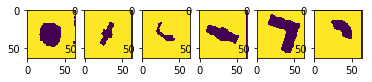

In [126]:
# output = decoder(latent)
output = decoder(z1*0.01)
print(output)
img = output.cpu().data[0,0,:,:]
img.clamp_(0,1)
img = img.numpy()
img = recover_img(img, True)
# print(img)
# plt.imshow(img)
output2 = decoder(latent)
imgs = [img]
for i in range(5):
    img = output2.cpu().data[i,0,:,:]
    img.clamp_(0,1)
    img = img.numpy()
    imgs.append(recover_img(img, True))
#     plt.imshow(img)
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(imgs[i])
    
plt.show()